In [1]:
 
from google.colab import drive
drive.mount('/content/drive')
#!git clone https://github.com/ANSSI-FR/ASCAD
#!pip install keras numpy h5py matplotlib tensorboardx tqdm
import os
import os.path
import sys
import h5py
import numpy as np
import pickle
 
import math
import matplotlib.pyplot as plt
import datetime, os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import scipy.fft as fft

 
 
#from tensorboardX import SummaryWriter
%matplotlib inline
plt.rcParams.update({'font.size': 22})

Mounted at /content/drive


In [2]:
# https://github.com/ANSSI-FR/ASCAD ATMega8515
ASCAD_DATASET_D100 = '/content/drive/My Drive/datasets/ASCAD_desync100.h5'
ASCAD_DATASET_D50 = '/content/drive/My Drive/datasets/ASCAD_desync50.h5'
ASCAD_DATASET_SYNC = '/content/drive/My Drive/datasets/ASCAD.h5'

#https://ctf.newae.com/media/trace/traces57.7z
CHES2016_PATH = '/content/drive/MyDrive/datasets/CW_Lite_CHES2016/'

In [3]:
import pywt
OUTPUT_COUNT = 1
CUDA = 1
device = 'cuda'

In [4]:

class MLP(nn.Module):
    def __init__(self, class_count, input_size):
        super(MLP, self).__init__()

        self.trace_analyze = nn.Sequential(
            nn.Linear(input_size, 20, bias=True),
            nn.ReLU(),
            #nn.Dropout(p=0.5)
            )
        self.decoder = nn.Sequential(
            #nn.Linear(20, 10, bias=True),
            #nn.LeakyReLU(),
            nn.Linear(20, 256, bias=True),
            nn.Sigmoid()
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x, plain):
        
        x = x.view(x.size(0), -1)
        #x = torch.cat((x, plain), 1)
        x = self.trace_analyze(x)
        return self.decoder(x)

    def get_first_weight(self):
        return self.trace_analyze[0].weight

    def loss(self, outputs, labels):
        return self.loss_fn(outputs, labels)

    def reinit(self):
        for param in self.parameters():
          torch.nn.init.normal_(param)


CUDA = torch.cuda.device_count()
device = 'cuda'

print(CUDA)
x = torch.ones((32,700))
x = x[:,None,:]
p = torch.ones((32,256))
plain = torch.ones((32,8))

net = MLP(1, 700)
if False and CUDA:
  x.to(device)
  net.to(device)
  p = p.cuda()
  p = p.float()
#print(torch.ones((5,50))[:,5])
print(net)
net.reinit()
out=net(x, plain)
print(out.shape)
loss = net.loss(out, p)
loss.backward()
pytorch_total_params = sum(p.numel() for p in net.parameters())
print("Param_count: {}".format(sum(p.numel() for p in net.parameters())))

1
MLP(
  (trace_analyze): Sequential(
    (0): Linear(in_features=700, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (loss_fn): MSELoss()
)
torch.Size([32, 256])
Param_count: 19396


In [5]:

class HW_labeling():
  hw_func = lambda x: sum(((x>>i)&1 for i in range(8)))
  class_count = 9
  
  @staticmethod
  def get_class_count(*args, **kwargs):
    return HW_labeling.class_count

  @staticmethod
  def __call__(intermidiate_values):
    return np.array(list(map(HW_labeling.hw_func, intermidiate_values)))

  def one(self, x):
    return HW_labeling.hw_func(x)
  
  @staticmethod
  def __str__():
    return "HW_labeling()"

class Binary_HW_labeling():
  hw_func = lambda x: 1 if sum(((x>>i)&1 for i in range(8))) > 3 else 0
  class_count = 2
  
  @staticmethod
  def get_class_count(*args, **kwargs):
    return Binary_HW_labeling.class_count

  @staticmethod
  def __call__(intermidiate_values):
    return np.array(list(map(Binary_HW_labeling.hw_func, intermidiate_values)))
  
  def one(self, x):
    return Binary_HW_labeling.hw_func(x)
  
  @staticmethod
  def __str__():
    return "Binary_HW_labeling()"

class LSB_labeling():
  class_count = 2
  
  @staticmethod
  def get_class_count(*args, **kwargs):
    return LSB_labeling.class_count

  @staticmethod
  def __call__(intermidiate_values):
    return np.array(intermidiate_values) % 2
  
  @staticmethod
  def one(x):
    return x % 2

  @staticmethod
  def __str__():
    return "LSB_labeling()"

class MSB_labeling():
  class_count = 2
  
  @staticmethod
  def get_class_count(*args, **kwargs):
    return MSB_labeling.class_count

  @staticmethod
  def __call__(intermidiate_values):
    return (np.array(intermidiate_values) > 127).astype(np.int8)

  @staticmethod
  def one(x):
    return int(x > 127)

  @staticmethod
  def __str__():
    return "MSB_labeling()"

class Bit_labeling():
  class_count = 2

  def __init__(self, bit_number=0):
    self.bit=bit_number
  
  @staticmethod
  def get_class_count(*args, **kwargs):
    return Bit_labeling.class_count

  def __call__(self, intermidiate_values):
    return np.array(list(map(lambda x: (x >> self.bit) % 2, intermidiate_values)))

  def one(self, x):
    return (x >> self.bit) % 2

  def __str__(self):
    return "Bit_labeling({})".format(self.bit)

<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>
traces shape: (20480, 700)
NofTraces: 20480
KEY: 224
labels_HW.shape=(20480, 256)
hw_statistic.shape=(256, 9)
<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>
traces shape: (4096, 700)
NofTraces: 4096
KEY: 224
labels_HW.shape=(4096, 256)
hw_statistic.shape=(256, 9)
tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0])
tensor([250, 194, 144,   4, 140, 113, 229, 225, 244, 200, 220, 203, 115, 115,
         80, 194,  68,  50,  33, 191, 134,  65, 245, 145,  59, 236, 144, 127,
         75, 213, 162,  53])


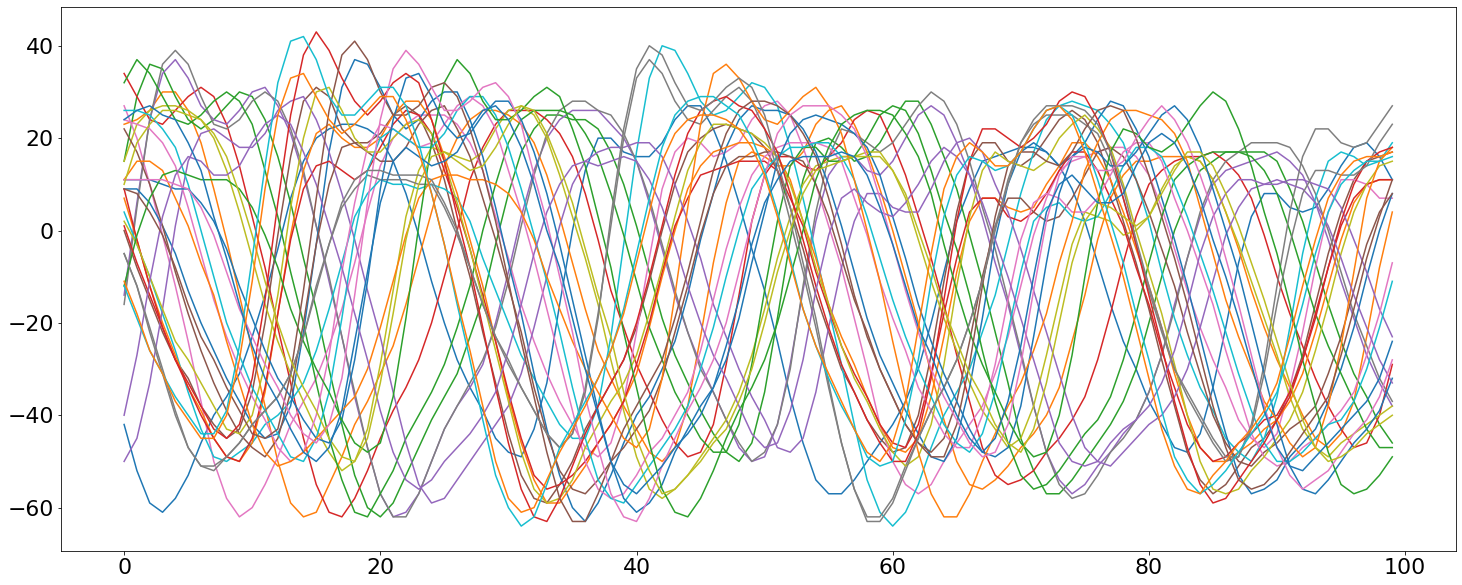

In [14]:

### from ASCAD github
def check_file_exists(file_path):
    file_path = os.path.normpath(file_path)
    if os.path.exists(file_path) == False:
        print("Error: provided file path '%s' does not exist!" % file_path)
        sys.exit(-1)
    return

#### ASCAD helper to load profiling and attack data (traces and labels)
# Loads the profiling and attack datasets from the ASCAD
# database
def load_ascad(ascad_database_file, load_metadata=False):
    check_file_exists(ascad_database_file)

    # Open the ASCAD database HDF5 for reading
    in_file = h5py.File(ascad_database_file, "r")
    print(in_file.keys())

    # Load profiling traces
    X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
    # Load profiling labels
    Y_profiling = np.array(in_file['Profiling_traces/labels'])
    # Load attacking traces
    X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
    # Load attacking labels
    Y_attack = np.array(in_file['Attack_traces/labels'])
    KEY = np.array(in_file['Profiling_traces/metadata'][2][2])
    if load_metadata == False:
        return (X_profiling, Y_profiling), (X_attack, Y_attack)
    else:
        return (X_profiling, Y_profiling), (X_attack, Y_attack), (
        in_file['Profiling_traces/metadata'], in_file['Attack_traces/metadata'])


AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

def print_traces(traces, med):

  formats = ['b', 'r','g','k'	,'m','y','c']
  plt.figure(figsize=(25, 25))
  for i, tr in enumerate(traces[:3]):
    plt.plot(range(len(tr)), tr, formats[i]+'-', alpha=0.5)
    plt.plot(range(len(med[i])),med[i], formats[i]+'--')
  plt.show()


# Our labelization function:
# It is as simple as the computation of the result of Sbox(p[2] + k[2]) (see the White Paper)
# Note: you can of course adapt the labelization here (say if you want to attack the first byte Sbox(p[0] + k[0])
# or if you want to attack another round of the algorithm).
def labelize(plaintexts, keys):
	return AES_Sbox[plaintexts[:, 2] ^ keys[:, 2]] ## on first round



bit_labeling =  Bit_labeling()
lsb_labeling = LSB_labeling()

def norm1(traces):
    traces= traces.astype(np.float64)
    _min = np.min(traces, axis=1).reshape(traces.shape[0], 1)
    traces = traces - _min
    _max = np.max(traces, axis=1).reshape(traces.shape[0], 1)
    traces = traces / _max -0.5
    return traces

def norm2(traces):
    mean = np.mean(traces, axis=1).reshape(traces.shape[0], 1)
    std = np.std(traces, axis=1).reshape(traces.shape[0], 1)
    traces = np.divide(traces - mean , std, dtype=np.float64)
    traces = np.divide(traces , np.max(np.abs(traces), axis=1).reshape(traces.shape[0], 1), dtype=np.float64)
    print("b",traces[0,:10])
    return traces


def norm(traces):
  _min = np.min(traces)
  traces = traces - _min
  _max = np.max(traces)
  return (traces / _max) - 0.5

def mooving_average(arr, n=3):
  r = np.cumsum(arr, axis=1,dtype=np.float64)
  r = r[:,n:] - r[:,:-n]
  pad_size = arr.shape[1] - r.shape[1]
  pad2 = np.zeros((r.shape[0],pad_size//2))
  pad1 = np.zeros((r.shape[0],pad_size - pad_size//2))
  r = np.concatenate((pad1, r,pad2),axis=1)

  return r / n


def traces_preprocessing(traces):
    begin_shape = traces.shape
    #traces = traces.astype(np.float64)        
    
    #traces = norm2(traces)
    MODE = 0
    if MODE == 0:
      return traces
      #traces = mooving_average(traces, n=104)
      #traces = np.convolve(traces, np.ones(N)/N, mode='valid')
      mean =  np.mean(traces, axis=0)
      #std = np.std(traces, axis=0)
      traces = (traces - mean) 
      traces = norm(traces)

      #med = np.zeros_like(traces)
      
      #print_traces(traces[:,:100], med[:,:100])
    elif MODE == 1:
      print("Computing furie transform...")
      furie = fft.fft(traces, axis=1)
      real = norm2(furie.real)
      imag = norm2(furie.imag)
      
      traces[:,:begin_shape[1]//2] = real[:,:begin_shape[1]//2]
      traces[:,begin_shape[1]//2:] = imag[:,begin_shape[1]//2:]

      mean =  np.mean(traces, axis=0)
      std = np.std(traces, axis=0)
      traces = (traces - mean) / std
    elif MODE == 2:
      
      traces = traces + 70
      print(f"preprocess max val:  {traces.max()}")
      traces = (traces/ 120) - 0.5
      traces = np.tan(traces * np.pi * 0.50)

    return traces


class ASCAD_nonprofiled_dataset(Dataset):
    def __init__(self, filename, byte_index, _transforms=None, lebeling_func=None, count=2000, start_index=0):

        if lebeling_func is None:
          lebeling_func = LSB_labeling()
        self.lebeling_func = lebeling_func

        self.name = filename.split('/')[-1][:-3]


        hw_labeling = HW_labeling()

        data, _, metadata = load_ascad(filename, load_metadata=True)
        metadata = metadata[0]
        key = metadata[0][2][byte_index] # (0 trace, 2 column)
        self.key = key
        self.traces = data[0][start_index:start_index + count] 
        self.traces = traces_preprocessing(self.traces)
        self.element_shape = self.traces.shape[-1] # first dim is count
        print(f"traces shape: {self.traces.shape}")

        print(f"NofTraces: {len(self.traces)}")
        self.labels = []
        self.plain = []
        self.labels_HW = []
        p = 0
        for meta in metadata[start_index:start_index + count]:
          pt = meta[0][byte_index]
          self.plain.append(pt)
          r_in = meta[3][14]
          r_out = meta[3][15]
          assert meta[2][byte_index] == key
          if byte_index >= 2:
            r = meta[3][byte_index - 2]
          else:
            r = 0
          l_tmp = [AES_Sbox[ pt ^ k ]   for k in range(256)]
          #print(orig_labels[i], l[GOODKEY], l.index(orig_labels[i]))
          #assert orig_labels[i]==l[GOODKEY]
          l = lebeling_func(l_tmp)
          self.labels.append(l)
          self.labels_HW.append(hw_labeling(l_tmp))
          
        self.labels = np.array(self.labels)
        self.labels_HW = np.array(self.labels_HW)
        self.plain = np.array(self.plain, dtype=np.ndarray)
        print(f"KEY: {key}")
        print(f"labels_HW.shape={self.labels_HW.shape}")
        self.transforms = _transforms
        self.hw_statistic = np.array([np.sum(self.labels_HW == hw, axis=0) for hw in range(9)]).T
        print(f"hw_statistic.shape={self.hw_statistic.shape}")

    def get_class_count(self):
        return self.lebeling_func.get_class_count()

    def get_key(self):
        return self.key
    
    def get_elenemt_shape(self):
        return self.element_shape

    def __len__(self):
        return len(self.traces)

    def __str__(self):
        return self.name

    @staticmethod
    def has_validate_set():
        '''For ASCAD we have date for validating'''
        return True

    def __getitem__(self, index):
        sample = self.traces[index]
        labels = self.labels[index]
        pt = self.plain[index]
        hw = self.labels_HW[index]
        #if self.transforms:
        sample = torch.from_numpy(sample).float()
        labels = torch.from_numpy(labels).long()
        pt = torch.tensor(pt).long()
        hw = torch.tensor(hw).long()
        #print(sample.min(), sample.max())
        return sample, labels, pt #, hw

TRAIN_TRACE_COUNT = 20*1024
VALID_TRACE_COUNT = 4*1024
#select dataset
DATASET = ASCAD_DATASET_D100

LABELING_FUNC = LSB_labeling()
#LABELING_FUNC = HW_labeling()
trainset = ASCAD_nonprofiled_dataset(DATASET, 2, _transforms=None, lebeling_func=LABELING_FUNC, count=TRAIN_TRACE_COUNT)
validset = ASCAD_nonprofiled_dataset(DATASET, 2, _transforms=None, lebeling_func=LABELING_FUNC, count=VALID_TRACE_COUNT, start_index=TRAIN_TRACE_COUNT)

PRINT = True
def print_one_batch(dataset, r=None):
    
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    traces, labels_batch, pt = train_loader.__iter__().next()
    plt.figure(figsize=(25, 10))
    if PRINT:
        for tr in traces:
            if r is not None:
              plt.plot(tr[r[0]:r[1]])
            else:
              plt.plot(tr)
        plt.draw()
    print(labels_batch[:, 0])
    print(pt)

print_one_batch(trainset, r=(100,200))
# 54 sec

Desync 50
<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>
orig_labels.shape= (2048,)
traces.shape= (2048, 700)
KEY: 224, GOODKEY:224
NofTraces: 2048
Labels shape (2048, 2)
(2, 700)
max corr: 0.05400503455500383


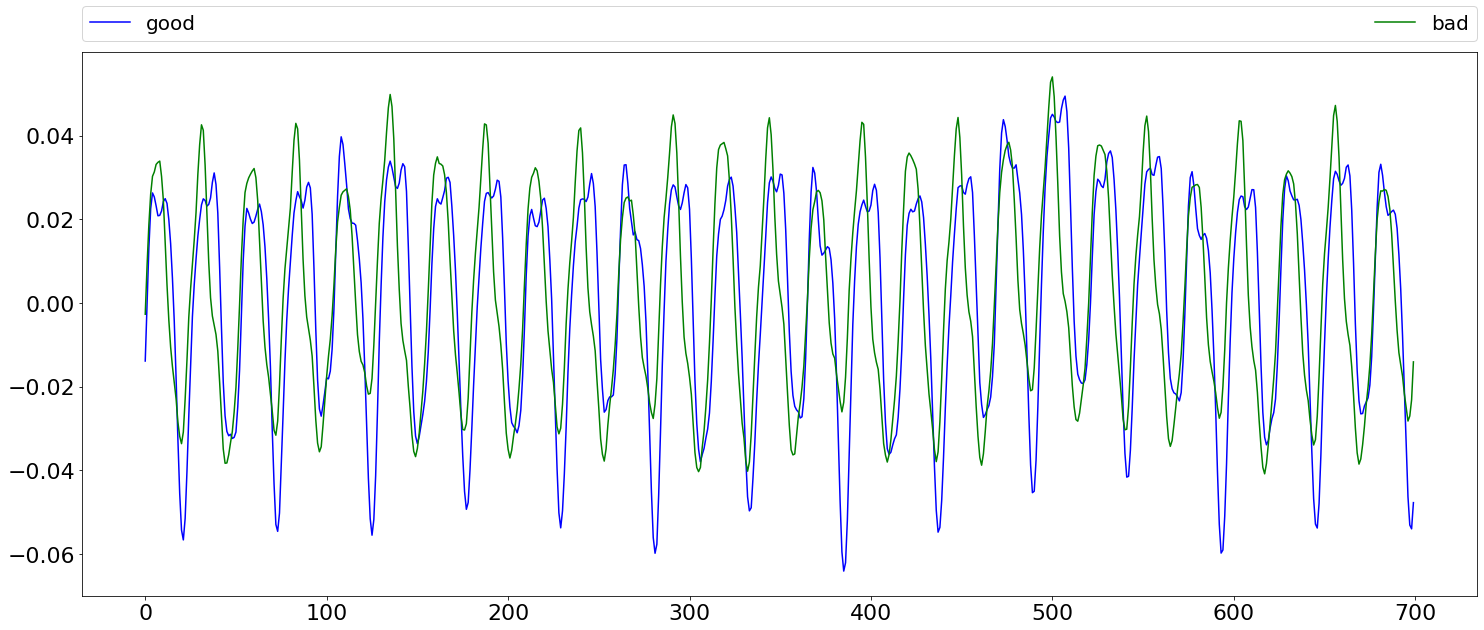

Sync
<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>
orig_labels.shape= (2048,)
traces.shape= (2048, 700)
KEY: 224, GOODKEY:224
NofTraces: 2048
Labels shape (2048, 2)
(2, 700)
max corr: 0.8466153777992316


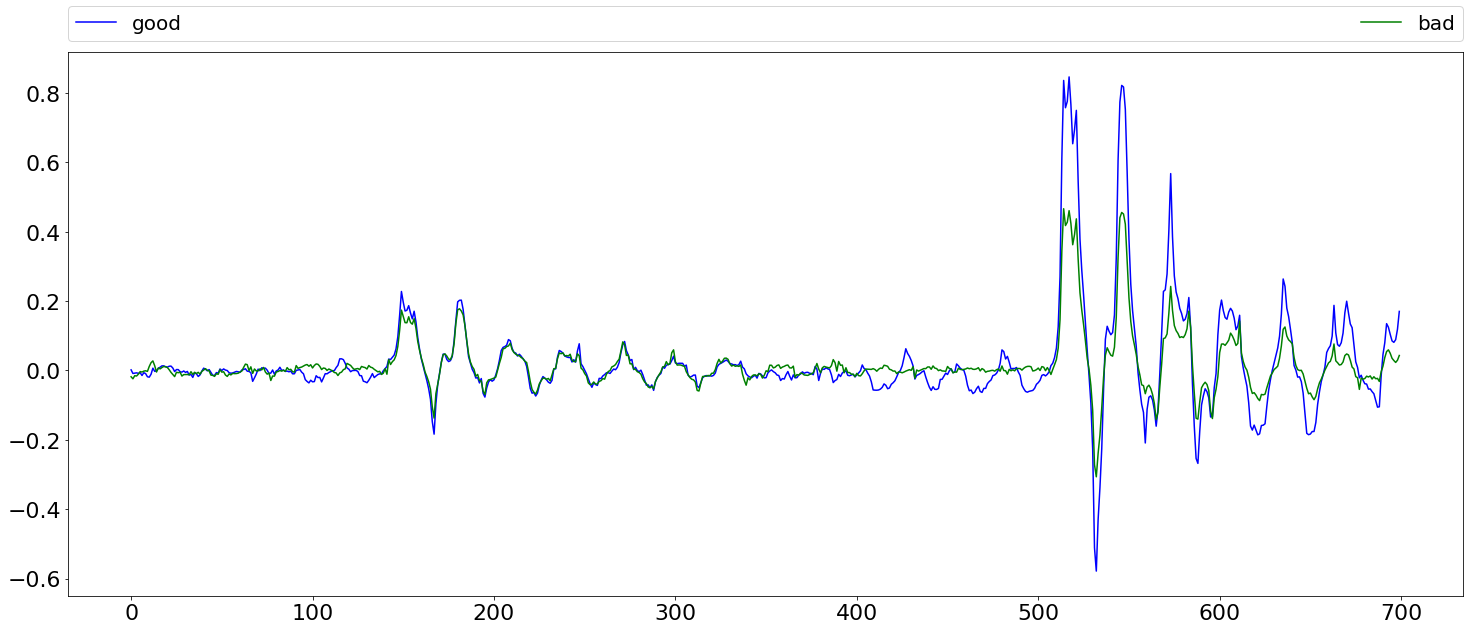

In [8]:
AES_Sbox1 = np.zeros_like(AES_Sbox)

def mooving_average(arr, n=3):
  r = np.cumsum(arr, axis=1,dtype=np.float64)
  r = r[:,n:] - r[:,:-n]
  return r / n

def cpa(traces, labels):
    '''
    traces: (bs, trace_len)
    labels: (bs, 256)
    '''
    kg_len = labels.shape[1]
    trace_len = traces.shape[1]
    mean = np.mean(traces, axis=0)
    traces = (traces - mean)
    r_i_j = np.dot(labels.T, traces) # 256x700
    zn = np.sqrt(np.dot(np.sum(labels**2,axis=0).reshape(kg_len, 1), np.sum(traces**2, axis=0).reshape(1,trace_len)) )
    r_i_j = r_i_j / zn
    return r_i_j

def CPA(filename, byte_index, count=2000):
        labeling = [HW_labeling(), LSB_labeling()]
        assert byte_index < 16
        data, _, metadata = load_ascad(filename, load_metadata=True)
        metadata = metadata[0]
        key = metadata[0][2][byte_index] # (0 trace, 2 column)
        traces = data[0][:count] 
        #traces = mooving_average(traces, n=100)
        #traces = traces_preprocessing(traces)

        #traces = traces[:,1:] - traces[:,:-1]
        #traces = traces - np.min(traces)
        #traces = traces/ np.max(traces) - 0.5
        
        
        orig_labels = data[1][:count]
        print("orig_labels.shape=",orig_labels.shape)
        print("traces.shape=",traces.shape)
        traces_count, trace_len = traces.shape
        
        GOODKEY=key
        print(f"KEY: {key}, GOODKEY:{GOODKEY}")
        print(f"NofTraces: {len(traces)}")
        labels = []
        p = 0

        if not isinstance(labeling, list):
          names = [str(l) for l in labeling]
        else:
          names = ["good", "bad"]
        key_guess = list(range(256))

        shiftes = []
        for i, meta in enumerate(metadata[:count]):
          pt = meta[0][byte_index]
          shiftes.append(meta[4][0])

          r_in = meta[3][14]
          r_out = meta[3][15]
          
          assert meta[2][byte_index] == key
          if byte_index >= 2:
            r = meta[3][byte_index - 2]
          else:
            r = 0
          if not isinstance(labeling, list):
            l = labeling([AES_Sbox[pt ^ k ] ^ r  for k in key_guess])
          else:
            l = [ l.one(AES_Sbox[pt ^ key ] ^ r) for l in labeling]
          #print(orig_labels[i], l[GOODKEY], l.index(orig_labels[i]))
          #assert orig_labels[i]==l[GOODKEY]
          #l = labeling(l)
          labels.append(l)

        kg_len = len(labels[0])
        labels = np.array(labels)
        l_mean = np.mean(labels, axis=0)
        labels = labels - l_mean

        print(f"Labels shape {labels.shape}")
        
        r_i_j = cpa(traces, labels)
        print(r_i_j.shape)
        
        print("max corr: {}".format(np.max(r_i_j)))
        plt.figure(figsize=(25, 10))
        if kg_len != 256:
          formats = ['b-', 'g-','r-','k-'	,'m-','y-','c-','b--']
          alphas = [ 1.0 for i in range(256)]
        else:
          formats = ['k-'if i != GOODKEY else 'r-' for i in range(256)]
          alphas = [0.2 if i != GOODKEY else 1.0 for i in range(256)]
          names = ['good key' if i == GOODKEY else '' if i!=0 else 'bad key' for i in range(256)]
        for i in range(kg_len):
          al = 0.2 if i!= GOODKEY else 1.0
          plt.plot(range(trace_len),r_i_j[i, :], formats[i % len(formats)], alpha=alphas[i], label=names[i % len(names)])
        plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
        plt.show()

print("Desync 50")
CPA(ASCAD_DATASET_D50, 2, count=2048)
print("Sync")
CPA(ASCAD_DATASET_SYNC, 2, count=2048)

Desync 100
<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>
orig_labels.shape= (2048,)
traces.shape= (2048, 700)
KEY: 224, GOODKEY:224
NofTraces: 2048
Labels shape (2048, 256)
398/399
Desync 50
<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>
orig_labels.shape= (2048,)
traces.shape= (2048, 700)
KEY: 224, GOODKEY:224
NofTraces: 2048
Labels shape (2048, 256)
398/399
Sync
<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>
orig_labels.shape= (2048,)
traces.shape= (2048, 700)
KEY: 224, GOODKEY:224
NofTraces: 2048
Labels shape (2048, 256)
398/399


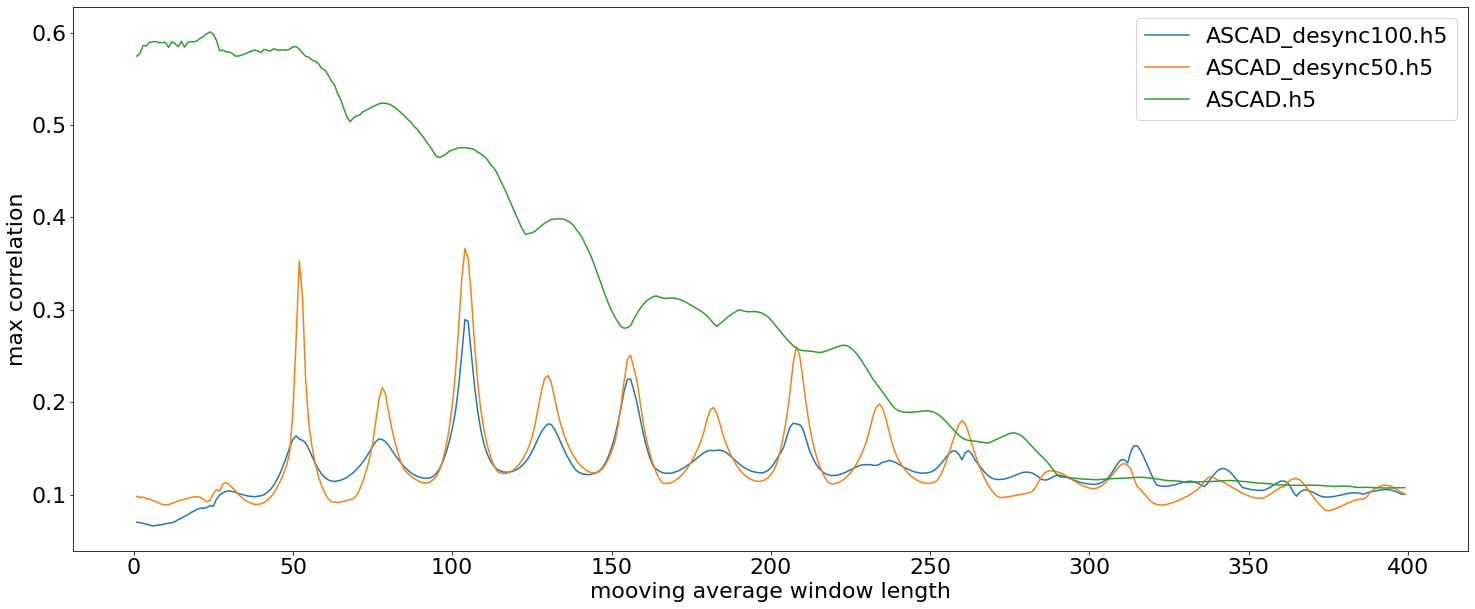

In [10]:
# Max correlation with mooving average
def Correlation_analysis(filename, byte_index, count=2000):
        labeling = Bit_labeling(4) #HW_labeling()#LSB_labeling()
        assert byte_index < 16
        data, _, metadata = load_ascad(filename, load_metadata=True)
        metadata = metadata[0]
        key = metadata[0][2][byte_index] # (0 trace, 2 column)
        traces = data[0][:count] 
        #traces = traces_preprocessing(traces)

        #traces = traces[:,1:] - traces[:,:-1]
        #traces = traces - np.min(traces)
        #traces = traces/ np.max(traces) - 0.5
        
        
        orig_labels = data[1][:count]
        print("orig_labels.shape=",orig_labels.shape)
        print("traces.shape=",traces.shape)
        traces_count, trace_len = traces.shape
        
        GOODKEY=key
        print(f"KEY: {key}, GOODKEY:{GOODKEY}")
        print(f"NofTraces: {len(traces)}")
        labels = []
        p = 0

        names = 'r, AES_Sbox[pt ^ key ] ^ r, AES_Sbox[pt ^ key ] ^ r_out, r_in, r_out,  AES_Sbox[pt ^ key ^ r_in] ^ r_out'.split(',')
        key_guess = list(range(256))

        shiftes = []
        for i, meta in enumerate(metadata[:count]):
          pt = meta[0][byte_index]
          shiftes.append(meta[4][0])

          r_in = meta[3][14]
          r_out = meta[3][15]
          
          assert meta[2][byte_index] == key
          if byte_index >= 2:
            r = meta[3][byte_index - 2]
          else:
            r = 0
          l = [AES_Sbox[pt ^ k ] ^ r  for k in key_guess]
          l = labeling(l)
          labels.append(l)

        kg_len = len(labels[0])
        labels = np.array(labels)
        l_mean = np.mean(labels, axis=0)
        labels = labels - l_mean

        print(f"Labels shape {labels.shape}")
        
        T = 0.29
        max_correlations = []
        x = np.array(list(range(1, 400, 1)))
        cur_max, idx_max = 0, 0
        xlen = len(x)
        for i,v in enumerate(x):
          print("\r{}/{}".format(i,xlen),end='')
          preprocessed_traces = mooving_average(traces, n=v)
          r_i_j = cpa(preprocessed_traces, labels)
          m = np.max(r_i_j)
          max_correlations.append(m)

        max_correlations = np.array(max_correlations)
        print()
        indices = max_correlations > T
        #print(max_correlations[indices])
        #print(x[indices])
        #plt.plot(x, [T]*xlen, )
        plt.plot(x, max_correlations, label='{}'.format(filename.split('/')[-1]))

plt.figure(figsize=(25, 10))
print("Desync 100")
Correlation_analysis(ASCAD_DATASET_D100, 2, count=2048)
print("Desync 50")
Correlation_analysis(ASCAD_DATASET_D50, 2, count=2048)
print("Sync")
Correlation_analysis(ASCAD_DATASET_SYNC, 2, count=2048)
plt.ylabel("max correlation")
plt.xlabel("mooving average window length")
plt.legend()
plt.show()

class_count: 2
traces shape: (1000, 700)
pt shape: (1000, 16)
key shape: [152 169  10 198 162 188  38  73  60  59 224  75  17  53  85 212]
key: [152 169  10 198 162 188  38  73  60  59 224  75  17  53  85 212]
tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0])
tensor([ 20, 226,  87, 225, 202, 242, 240, 253, 206, 202, 104, 182, 196, 235,
        135, 131,   4, 195, 182,  96, 139, 198, 134,  24, 143,   7, 201,   3,
         76, 242,  50, 204])


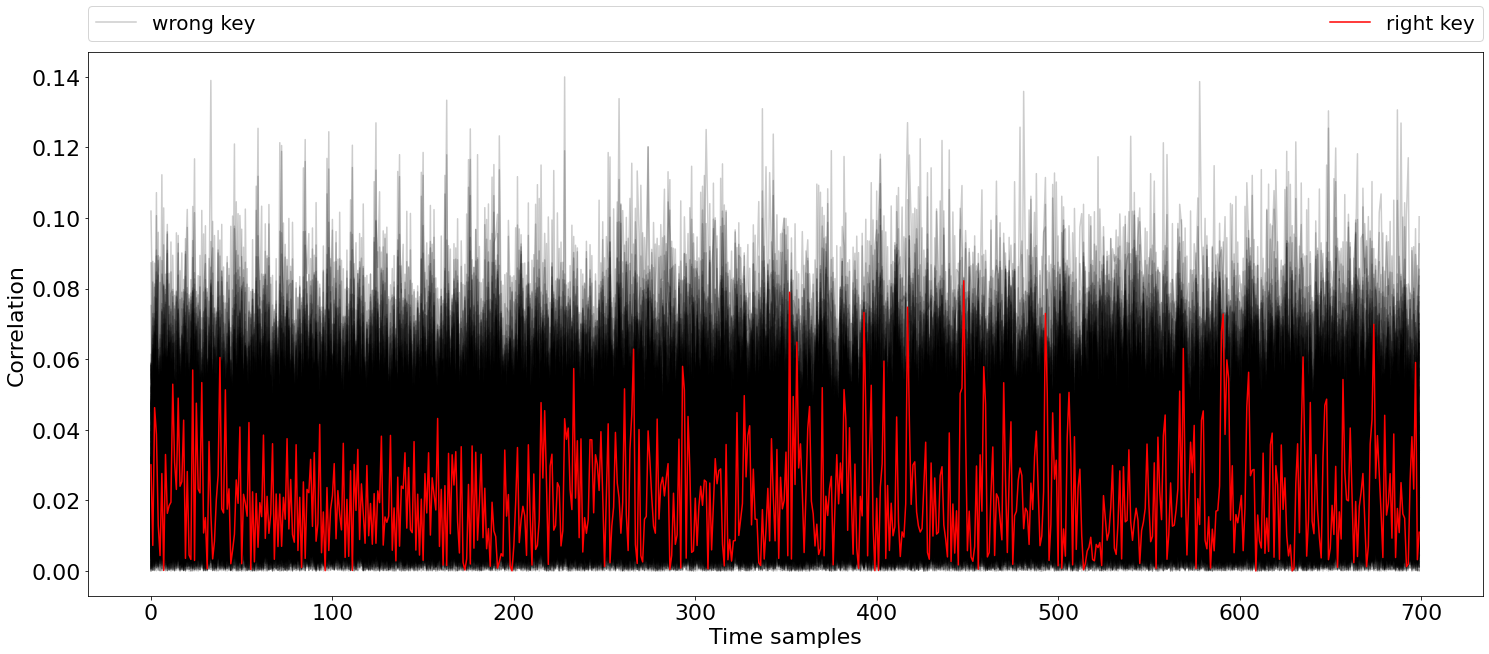

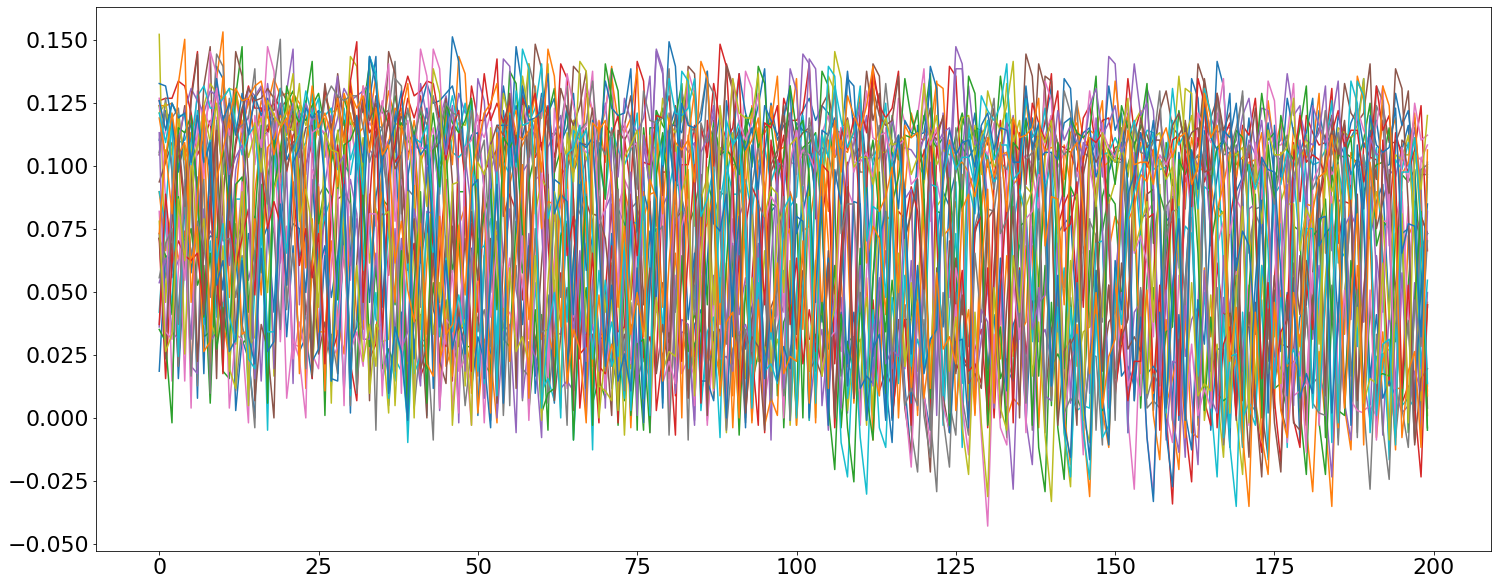

In [11]:
def align(traces, hi=100):
    shifts = np.random.randint(low=1, high=hi, size=traces.shape[0])
    for i,s in enumerate(shifts):
      traces[i,0:-s] = traces[i,s:]
    return traces[:,hi:]
    
def norm_2(traces):
  _min = np.min(traces)
  traces = traces - _min
  _max = np.max(traces)
  return (traces / _max) - 0.5


class CHES_nonprofiled_dataset(Dataset):
    def __init__(self):

        lebeling_func = Bit_labeling(7)
        self.lebeling_func = lebeling_func
        print("class_count: {}".format(self.get_class_count()))

        path = '/content/drive/MyDrive/datasets/CW_Lite_CHES2016/'
        dir = 'traces_CPA' #'traces_desync' 
        self.traces = np.load(path + dir + '/traces.npy')
        self.key =    np.load(path + dir + '/knownkey.npy')
        self.pt =     np.load(path + dir + '/textin.npy')
        if 0:
          tile = 4
          self.traces = np.tile(self.traces, (tile,1))
          self.pt = np.tile(self.pt, (tile,1))

        
        
        self.align = 100
        if self.align:
          self.traces = align(self.traces, hi=self.align)

        

        self.traces = self.traces[:,300:1000]

        #self.traces = self.traces + 0.1*np.random.normal(size=self.traces.shape)

        #self.traces = mooving_average(self.traces, n=16)
        self.element_shape = self.traces.shape[1]
        print("traces shape:", self.traces.shape)
        print("pt shape:", self.pt.shape)
        print("key shape:", self.key)
        print("key:", self.key)
        GOODKEY = self.key[0]


        #self.traces = norm_2(self.traces)
        self.labels = []
        self.plain = []
        self.labels_HW = []
        p = 0
        
        for p in self.pt:
          l_tmp = [AES_Sbox[ p[0] ^ k ]  for k in range(256)]

          l = lebeling_func(l_tmp)
          self.labels.append(l)
          
        self.labels = np.array(self.labels)
        names = 'r, AES_Sbox[pt ^ key ] ^ r, AES_Sbox[pt ^ key ] ^ r_out, r_in, r_out, pt ^ r, pt ^ r ^ key, r ^ key,pt ^ r_in, pt ^ r_out'.split(',')
        
        labels = self.labels
        kg_len = labels.shape[1]
        labels = np.array(labels)
        l_mean = np.mean(labels, axis=0)
        labels = labels - l_mean

        #print(f"Labels shape {labels.shape}")

        traces = self.traces
        trace_len = traces.shape[1]
        mean = np.mean(traces, axis=0)
        traces = (traces - mean)
        #print(f"Traces shape {traces.shape}")


        r_i_j = np.dot(labels.T, traces) # 256x700
        zn = np.sqrt(np.dot(np.sum(labels**2,axis=0).reshape(kg_len, 1), np.sum(traces**2, axis=0).reshape(1,trace_len)) )

        r_i_j = r_i_j / zn
        #print(r_i_j.shape)
        #print("Labling func:",labelings[a])
        plt.figure(figsize=(25, 10))
        if kg_len == 256:
          formats = ['k-'if i != GOODKEY else 'r-' for i in range(256)]
          alphas = [0.2 if i != GOODKEY else 1.0 for i in range(256)]
        good_param = []
        for i in range(kg_len):
          if  kg_len != 256:
            plt.plot(range(trace_len),r_i_j[i, :], label=names[i])
          else:
            if i != GOODKEY:
              if i == 0:
                plt.plot(range(trace_len),np.abs(r_i_j[i, :]),formats[i], alpha=alphas[i], label='wrong key')
              else:
                plt.plot(range(trace_len),np.abs(r_i_j[i, :]),formats[i], alpha=alphas[i])
            else:
              good_param = [range(trace_len), np.abs(r_i_j[i, :]),'r-']
        plt.plot(*good_param, label='right key')

        plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
        
        plt.xlabel("Time samples")
        plt.ylabel("Correlation")
        plt.draw()
        SAVE_DATA = False
        if SAVE_DATA:
          save_data = ["CHES MSB", good_param[1], ["AES_Sbox[pt ^ key]"]]
          with open('/content/drive/My Drive/datasets/article_results/{}_.pickle'.format("CHES_correlation"), 'wb') as f:
            pickle.dump(save_data, f)

    def get_class_count(self):
        return self.lebeling_func.get_class_count()

    def get_key(self):
        return self.key[0]
    
    def get_elenemt_shape(self):
        return self.element_shape

    def __len__(self):
        return len(self.traces)
    
    def __str__(self):
      if self.align == 0:
        return "CHES2016"
      else:
        return "CHES2016_D{}".format(self.align)

    @staticmethod
    def has_validate_set(self):
        '''For CHES we have not date for validating'''
        return False

    def __getitem__(self, index):
        sample = self.traces[index]
        labels = self.labels[index]
        pt = self.pt[index,0]
        #if self.transforms:
        sample = torch.from_numpy(sample).float()
        labels = torch.from_numpy(labels).long()
        pt = torch.tensor(pt).long()
        #print(sample.min(), sample.max())
        return sample, labels, pt

ches_dataset = CHES_nonprofiled_dataset()
trainset = ches_dataset
print_one_batch(ches_dataset, r=(300,500))
#mac corr at 450 and 780
# 170 480

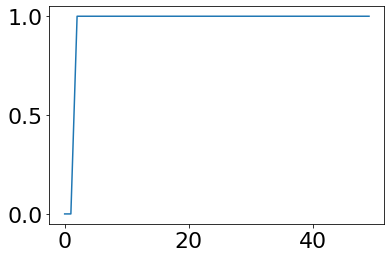

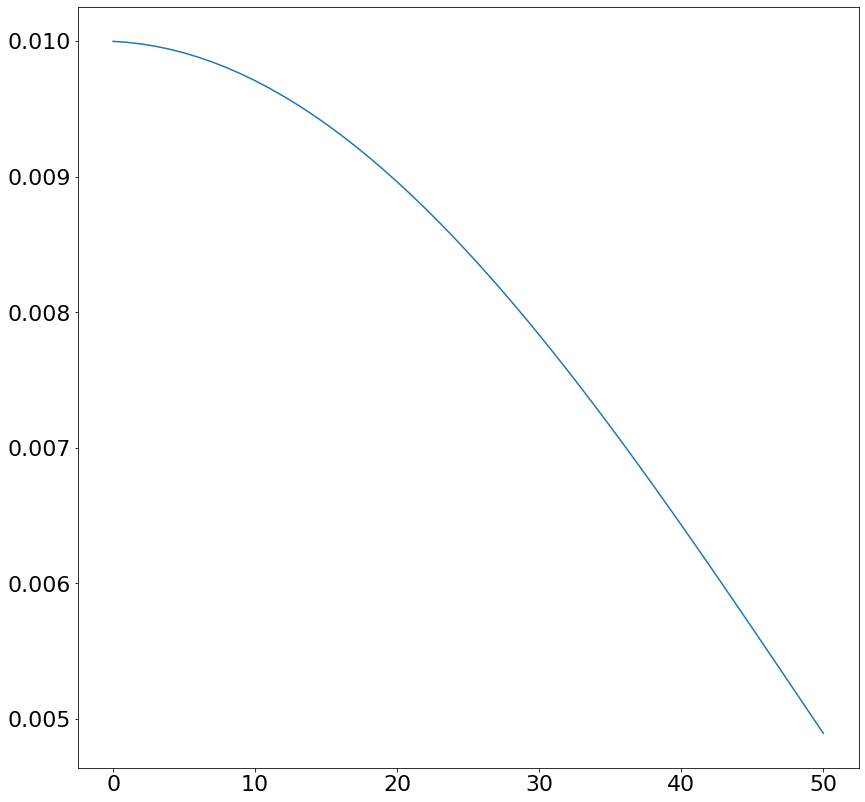

In [12]:
def grad_mul_coefs(epoch_count):
  return [0 if i < 2  else 1 for i in range(epoch_count)]

plt.figure()
plt.plot(grad_mul_coefs(50))
plt.show()

def plot(title, data, xlabel="epochs"):
    plt.figure(figsize=(25, 10))
    plt.ylabel(title)
    plt.plot(data, color='red')
    plt.xlabel(xlabel)
    plt.draw()

def plot256(title, data, good_idx, xlabel="epochs"):
    plt.figure(figsize=(25, 10))
    plt.ylabel(title)
    for i, d in enumerate(data):
      if i != good_idx:
        plt.plot(d, color='#a0a0a0', alpha=1, label='Wrong key' if i==0 else '')
    plt.plot(data[good_idx], color='red', alpha=1, label='Right key')
    plt.xlabel(xlabel)
    plt.legend(loc='best', fontsize=15)
    plt.draw()


def get_input_grad(loader, model, good_idx):
    traces, labels_batch, pt = loader.__iter__().next()
    traces = traces[:,None,:]
    if CUDA:
      traces = traces.to(device)    
      labels = labels_batch.float().view(traces.size(0),256).to(device)
    traces.requires_grad = True
    outputs = model(traces, labels) 

    predicted = (outputs.data > 0.5).type(torch.float16) 
    correct = 0
    total = 0
    correct += (predicted == labels).sum(0).cpu().detach().numpy()
    total += labels.size(0)

    print("grad accuracy: {}".format((correct/labels.size(0))[good_idx]))

    rights_traces_indices = ( predicted[:,good_idx] == labels[:,good_idx] ).nonzero(as_tuple=True)[0]
    last_dim_indices = [good_idx]*len(rights_traces_indices)
    #print(rights_traces_indices, last_dim_indices)
    loss = model.loss(outputs[rights_traces_indices,good_idx], labels[rights_traces_indices,good_idx])
    #loss = model.loss(outputs, labels)
    
    loss.backward()
    data = traces.grad.cpu().abs().sum(dim=0)[-1]
    return data


class MyWarmupCosineAnnealingLR(torch.optim.lr_scheduler._LRScheduler):
    r"""
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        linear_lr_m (int): линейная часть
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, linear_lr_m, T_max, eta_min=0, sin_max=0.01,last_epoch=-1):
        self.linear_lr_m = linear_lr_m
        self.T_max = T_max
        self.eta_min = eta_min
        self.sin_max = sin_max
        super(MyWarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        ''' копипаста cosine lr
        выдать список новых lr. base_lrs = [gr['init_lr'] for rg in opt.groups]'''
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        elif self.last_epoch <self.linear_lr_m:
            return [ (self.last_epoch + 1) * lr / self.linear_lr_m for lr in self.base_lrs]
        elif (self.last_epoch - self.linear_lr_m  - self.T_max) % (2 * self.T_max) == 0:
            return [group['lr'] + (self.sin_max - self.eta_min) *
                    (1 - math.cos(math.pi / self.T_max)) / 2
                    for base_lr, group in
                    zip(self.base_lrs, self.optimizer.param_groups)]
        return [(1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m +1) / self.T_max)) /
                (1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m ) / self.T_max)) *
                (group['lr'] - self.eta_min) + self.eta_min
                for group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m) / self.T_max)) / 2
                for base_lr in self.base_lrs]


class Optimizer():
    def __init__(self, params):
      self.optimizer = torch.optim.Adam(params, lr=0.01)
      linear_lr_m = 0
      T_max = 100
      self.epochs = 50
      eta_min = 0.0001
      SIN_MAX = 0.001

      self.sched =  MyWarmupCosineAnnealingLR(self.optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)
    
    def step(self):
      self.optimizer.step()
      self.sched.step()
    
    def get_current_lr(self):
      for param_group in self.optimizer.param_groups:
        return param_group['lr']

    def get_epochs_count(self):
      return self.epochs

    def zero_grad(self):
      return self.optimizer.zero_grad()



def test_lr():
  optimizer = Optimizer(nn.Linear(2,2).parameters())
  lrs = [optimizer.get_current_lr()]
  optimizer.step()
  for i in range(optimizer.get_epochs_count()):
      lrs.append(optimizer.get_current_lr()), optimizer.step()
  plt.figure(figsize=(14, 14))
  plt.plot(lrs)
  plt.show()

test_lr()

In [19]:
INTERNAL_LAYER = True


class SubAvg(nn.Module):
  def __init__(self, in_channels):
    super(SubAvg, self).__init__()
  
  def forward(self, x):   
    return x - torch.mean(x, 0)


class CNN(nn.Module):
    def __init__(self, class_count, input_size):
        super(CNN, self).__init__()

        if class_count == 2:
          class_count = 1

        layers = []
        x = torch.ones((2,1,input_size))
        print("Input size: {} class_count: {}".format(x.size(), class_count))


        pattern_finder = nn.Sequential(*[
                                         nn.Conv1d(1, 4, kernel_size=33, stride=1, dilation=1, padding=0, bias=False),
                                         ])

        layers.append(pattern_finder)
        x = pattern_finder(x)
        print("pattern_finder output size: {}".format(x.size()))


        sync =  nn.Sequential(*[      
                            
                #nn.BatchNorm1d(x.size(1), affine=True, track_running_stats=True),
                #nn.LeakyReLU(),
                nn.MaxPool1d(100, stride=100, padding=(0)),
                nn.BatchNorm1d(x.size(1), affine=True, track_running_stats=True),
                #SubAvg(x.size(1)),
                nn.LeakyReLU(),
                #nn.MaxPool1d(100, stride=100, padding=(0)),       
        ])
        layers.append(sync)
        x = sync(x)
        print(f"sync out: {x.size()}")
        #print(self.layers[0].weight.size())
        #nn.init.constant_(self.sync[0].weight[0], 1/4)
        #nn.init.constant_(self.sync[0].weight[1], -1/4)
        
        if INTERNAL_LAYER:
          if 1:
            ifilter_count = 32
            internal =  nn.Sequential(*[
                  nn.Conv1d(x.size(1), ifilter_count, kernel_size=x.size(2), stride=1, dilation=1, padding=0, bias=False),
                  nn.BatchNorm1d(ifilter_count, affine=True, track_running_stats=True),
                  nn.LeakyReLU(),
          ])
          else:
            internal =  nn.Sequential(*[
                  nn.AvgPool1d(x.size(2), padding=(0)),
            ])
          layers.append(internal)
          x = internal(x)
          print(f"internal out: {x.size()}")


        #mlp_size = x.view(x.size(0), -1).size(1)
        #print(f"3 size out: {mlp_size}")
        last = nn.Sequential(
            #nn.Linear(mlp_size, 20, bias=True),
            #nn.Linear(mlp_size, class_count, bias=True)
            nn.Conv1d(x.size(1), 256, kernel_size=x.size(2), stride=1, dilation=1, padding=0, bias=True),
            #nn.BatchNorm1d(256, affine=True, track_running_stats=True),
            nn.Sigmoid()
        )
        layers.append(last)

        self.net = nn.Sequential(*layers)
        self.loss_fn = nn.MSELoss()

        self.w = []
        self.bn = []
        self.last_patterns = None

    def forward(self, x, plain):
        x = self.net(x) 
        return x.view(x.size(0), -1)

    def reinit(self):
        for w in self.w:
          torch.nn.init.xavier_uniform_(w)
        for w in self.bn:
          torch.nn.init.zeros_(w)

    def get_weights(self):
        return [self.sync[0].weight[0,0,:].cpu().detach().numpy(),
               self.internal[0].weight.cpu().detach().numpy(),
               self.last[0].weight.cpu().detach().numpy(),
               ]
    
    def loss(self, outputs, labels):
        #val, idx = torch.max(self.last_patterns, 2, keepdim=False)
        #print(idx)
        #weights = torch.ones_like(self.last_patterns)
        #weights[:,:,idx] = 0
        #print(weights)
        #return sum([self.loss_fn(outputs[:,k], labels[:,k])/256 for k in range(256)]) #+ 1e-6 * ( self.last_patterns**2 * weights).sum()
        return self.loss_fn(outputs, labels)

    def get_first_weight(self):
        return self.sync[0].weight

    def get_weight(self):
        return self.sync[0].weight

CUDA = torch.cuda.device_count()
device = 'cuda'

print("CUDA =",CUDA)
x = torch.ones( [2] + [trainset.get_elenemt_shape()] )
x = x[:,None,:]

p = torch.ones((2,8))
l = torch.zeros((2,256))
net = CNN(2, trainset.get_elenemt_shape())
if CUDA:
  x = x.to(device)
  net = net.to(device)
  p = p.to(device)
  l = l.to(device)
#print(torch.ones((5,50))[:,5])
print(net)
print("test input size: ", x.size())
net.reinit()
out = net(x,p)
print(out.shape)
loss = net.loss(out, l)
loss.backward()
pytorch_total_params = sum(p.numel() for p in net.parameters())
print("Param_count: {}".format(pytorch_total_params))

CUDA = 1
Input size: torch.Size([2, 1, 700]) class_count: 1
pattern_finder output size: torch.Size([2, 4, 668])
sync out: torch.Size([2, 4, 6])
internal out: torch.Size([2, 16, 1])
CNN(
  (net): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 4, kernel_size=(33,), stride=(1,), bias=False)
    )
    (1): Sequential(
      (0): MaxPool1d(kernel_size=100, stride=100, padding=0, dilation=1, ceil_mode=False)
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv1d(4, 16, kernel_size=(6,), stride=(1,), bias=False)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv1d(16, 256, kernel_size=(1,), stride=(1,))
      (1): Sigmoid()
    )
  )
  (loss_fn): MSELoss()
)
test input size:  torch.Size([2, 1, 700])
torch.Size([2, 256])
Param_count: 4908


Input size: torch.Size([2, 1, 700]) class_count: 1
pattern_finder output size: torch.Size([2, 4, 668])
sync out: torch.Size([2, 4, 6])
internal out: torch.Size([2, 16, 1])
CNN(
  (net): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 4, kernel_size=(33,), stride=(1,), bias=False)
    )
    (1): Sequential(
      (0): MaxPool1d(kernel_size=100, stride=100, padding=0, dilation=1, ceil_mode=False)
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv1d(4, 16, kernel_size=(6,), stride=(1,), bias=False)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv1d(16, 256, kernel_size=(1,), stride=(1,))
      (1): Sigmoid()
    )
  )
  (loss_fn): MSELoss()
)
Otimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: F

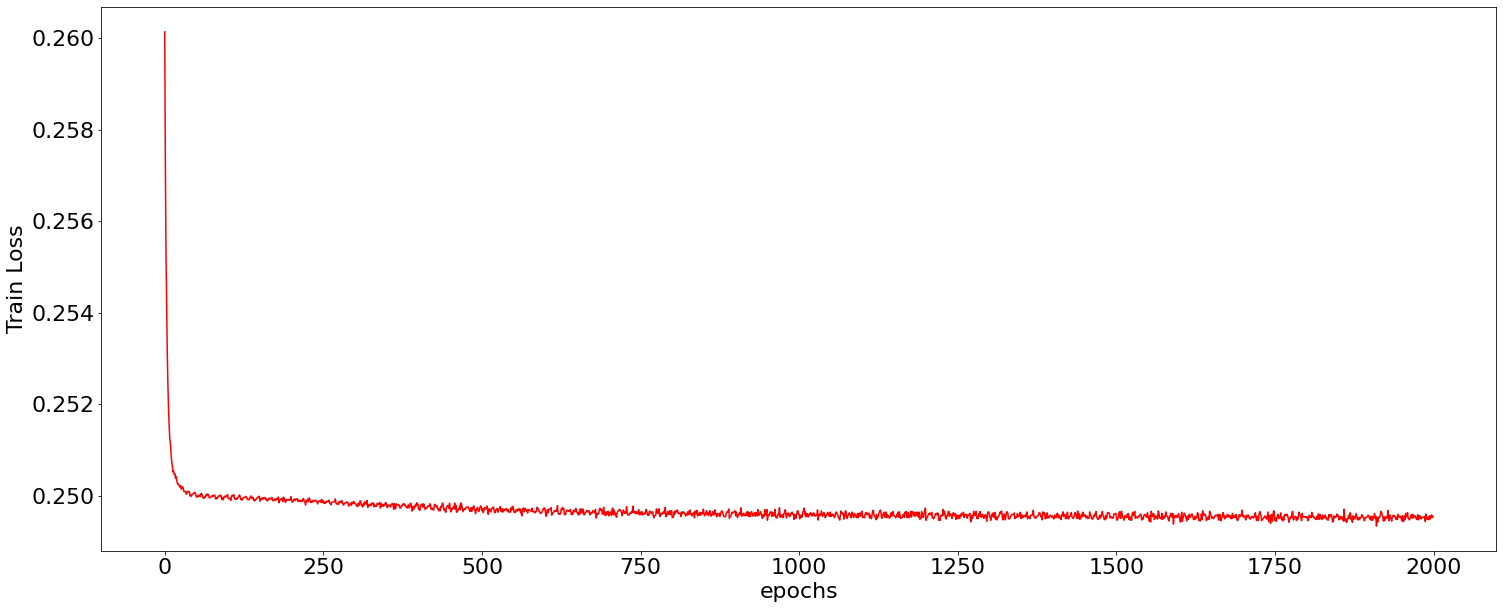

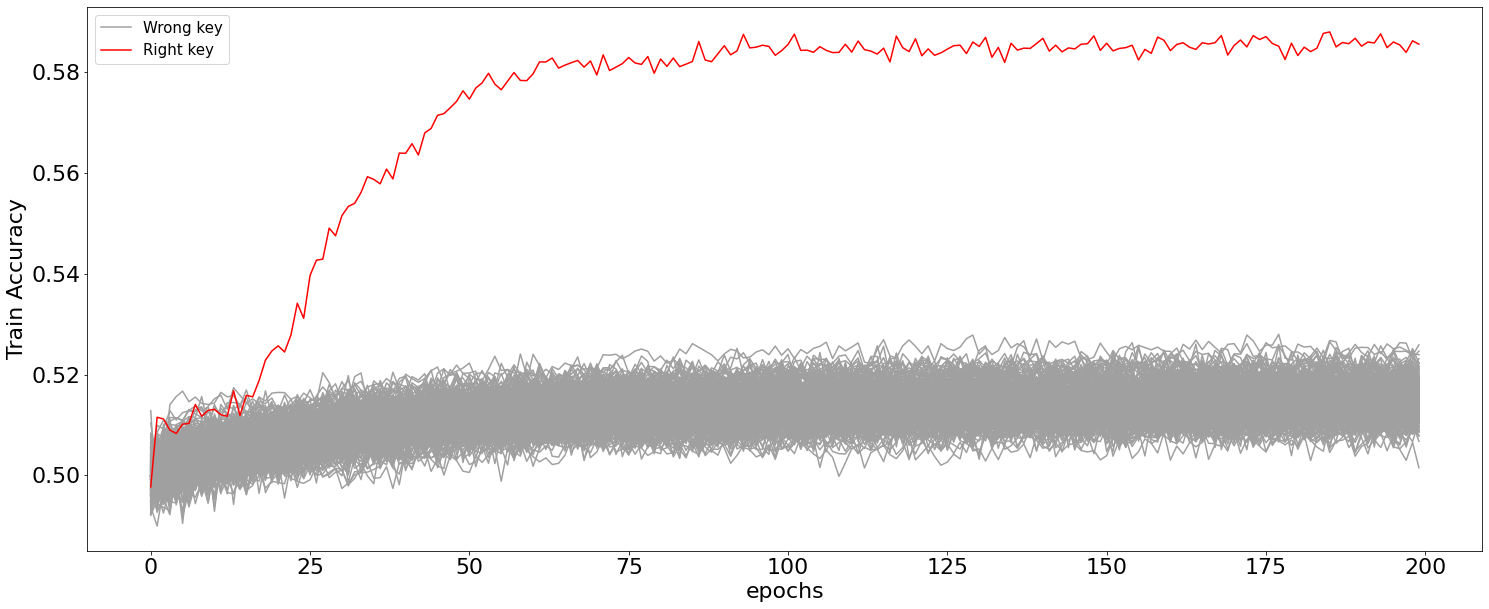

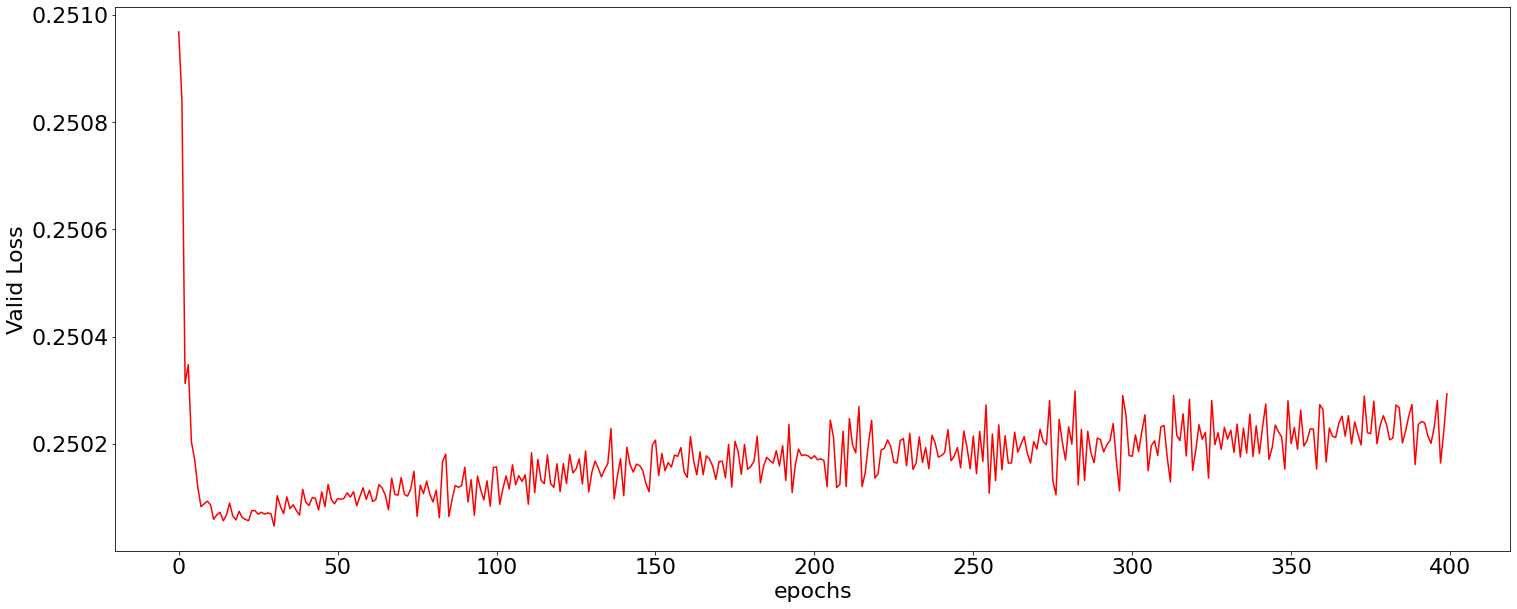

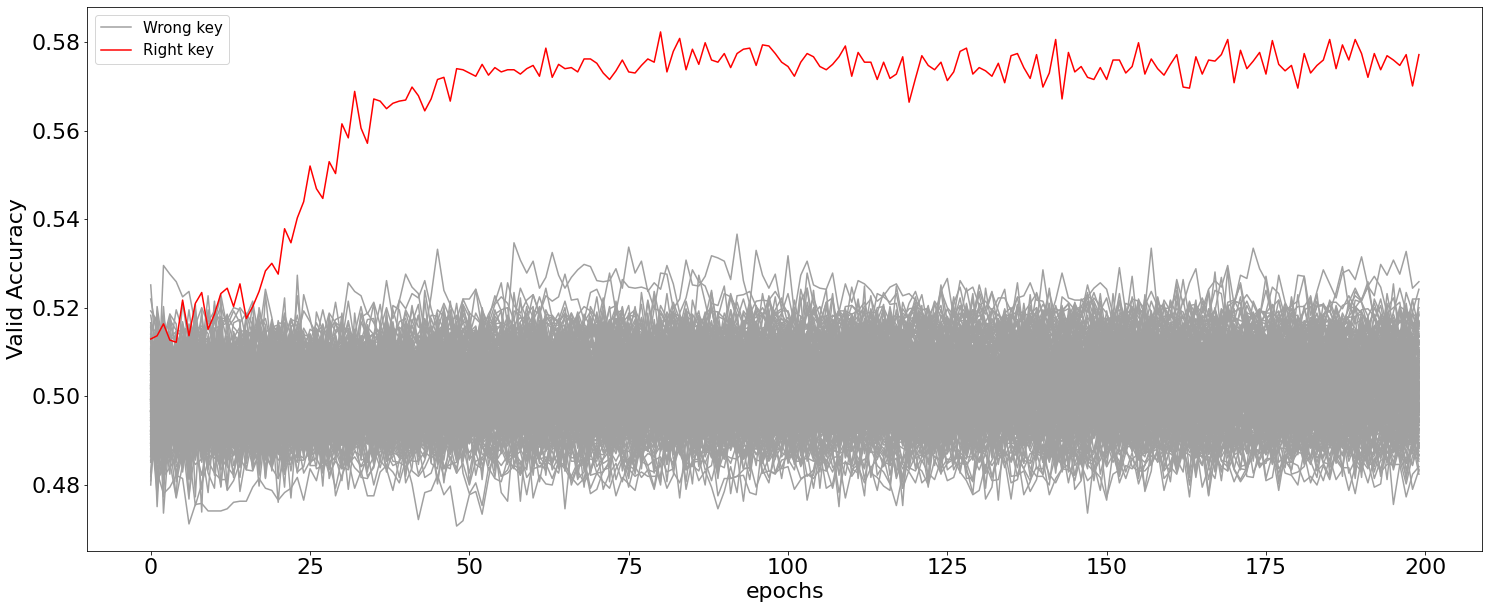

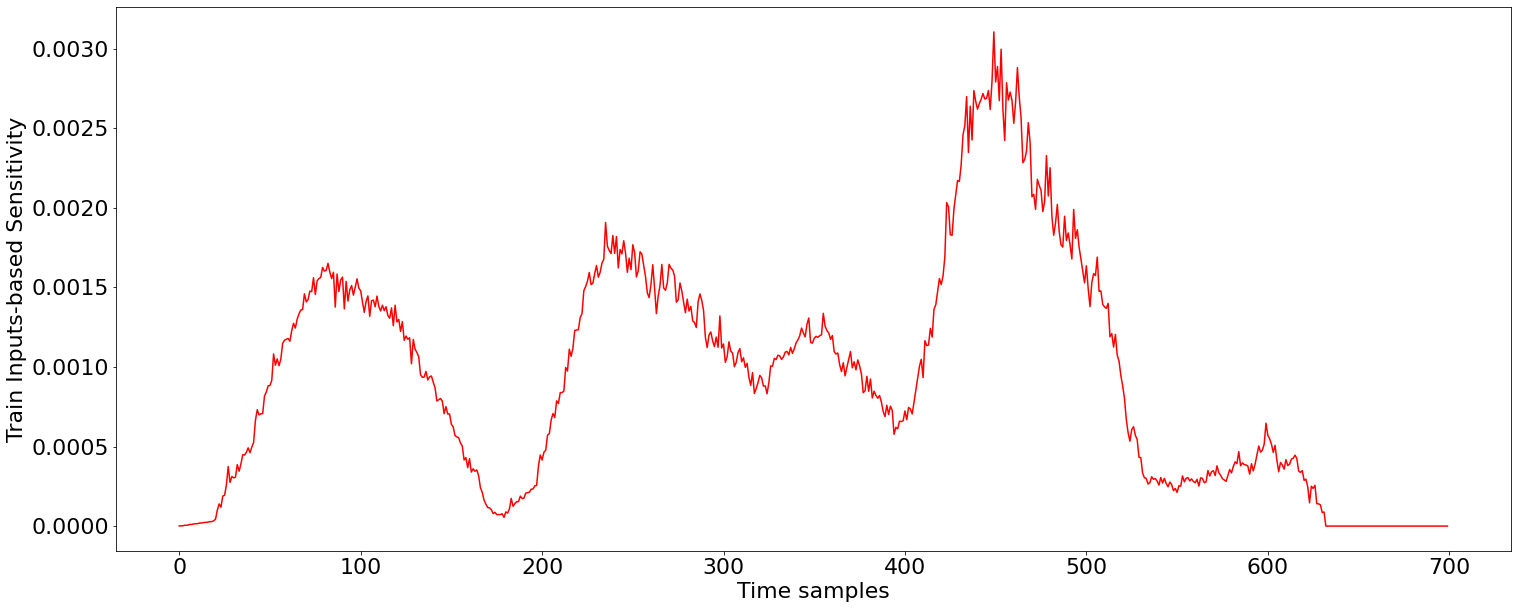

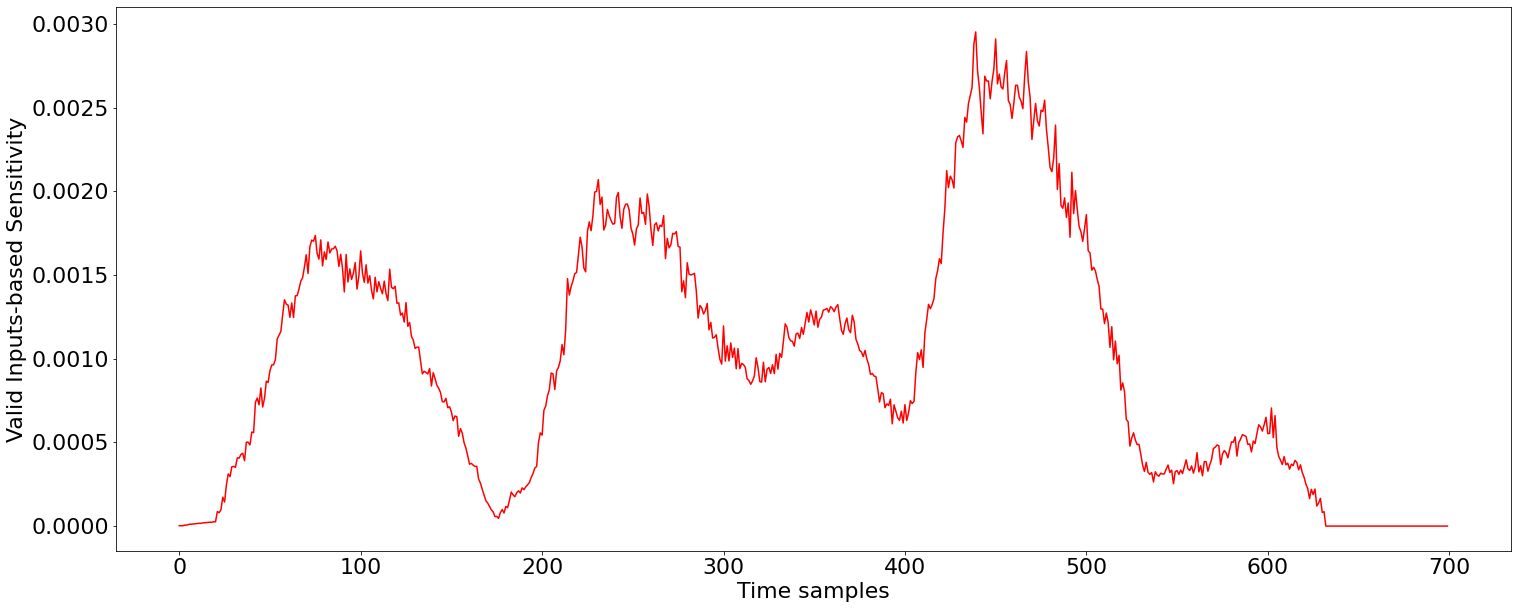

In [21]:
import gc, time
gc.collect()

EPOCH_START = 0
epochs = 200
BS = 2048


BR = False
VALID = trainset.has_validate_set()
SAVE_DATA = False
FILENAME = "CNN_"
#FILENAME = "ASCAD_k33_150epochs"
#BR = True

MODEL = CNN
model = MODEL(trainset.get_class_count(), trainset.get_elenemt_shape())
if CUDA:
  device = "cuda"
  model = model.to(device)

#optimizer = Optimizer(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#, weight_decay=1e-4)
print(model)
print("Otimizer:", optimizer)


train_loader = DataLoader(trainset, batch_size=BS, shuffle=True)
if VALID:
  valid_loader = DataLoader(validset, batch_size=BS, shuffle=True)

GOODKEY = trainset.get_key()
print(f"GOOD_KEY_INDEX={GOODKEY}")

valid_losses = []
train_losses = []
weights = []
biases = []
acc = []
vacc = []

start_time = datetime.datetime.now()
def train():
    global valid_losses, train_losses, weights, biases, model, optimizer
    print(f"Start trainitg at {start_time.strftime('%m.%d_%H:%M:%S')}")

    valid_losses = []
    train_losses = []

    weights = []
    biases = []


    if 1:


      #model.reinit()
     
      
      for epoch in range(epochs):
          epoch_start_time = time.time()
          model.train()

          
          grads = None
          w_grads = None

          correct = 0
          total = 0

          iter_count = len(train_loader)
          for i, data in enumerate(train_loader):
              epoch += EPOCH_START
              traces, labels_batch, pt = data
              traces = traces[:,None,:]
              #traces = traces

              #print(model.bn_list[3].bias)
              if CUDA:
                  traces = traces.to(device)
                  # labels (bs, 256, OUTPUT_COUNT)
                  labels = labels_batch.float().view(traces.size(0),256).to(device)
                  pt = pt.to(device)

                
              optimizer.zero_grad()
              traces.requires_grad = True
              #print(traces.size())
              outputs = model(traces, labels) #pt)

              predicted = (outputs.data > 0.5).type(torch.float16)
              correct += (predicted == labels).sum(0).cpu().detach().numpy()
              total += labels.size(0)

              #print(outputs, labels)

              loss = model.loss(outputs, labels)
                
              loss.backward()         

              optimizer.step()

              train_losses.append(loss.item())
              if BR:
                break
              #if USE_WRITER: writer.add_scalar(f"Iter/loss{j}",loss.item(), global_step=epoch*iter_count + i)
              #print(f"\r\ttraining {i}/{iter_count} _ loss {loss.item()}, ", end="") #reg_loss{reg_loss.item()}

          acc.append(correct/total)
          if VALID:
            vcorrect = 0
            vtotal = 0
            iter_count = len(valid_loader)
            for i, data in enumerate(valid_loader):
                epoch += EPOCH_START
                traces, labels_batch, pt = data
                traces = traces[:,None,:]
                #traces = traces

                #print(model.bn_list[3].bias)
                if CUDA:
                    traces = traces.to(device)
                    # labels (bs, 256, OUTPUT_COUNT)
                    labels = labels_batch.float().view(traces.size(0),256).to(device)
                    pt = pt.to(device)

                  
                optimizer.zero_grad()
                traces.requires_grad = True

                outputs = model(traces, labels) # pt)

                predicted = (outputs.data > 0.5).type(torch.float16) 
                vcorrect += (predicted == labels).sum(0).cpu().detach().numpy()
                vtotal += labels.size(0)

                #print(labels)

                loss = model.loss(outputs, labels)
                

                valid_losses.append(loss.item())

                if BR:
                  break
                #if USE_WRITER: writer.add_scalar(f"Iter/loss{j}",loss.item(), global_step=epoch*iter_count + i)
                #print(f"\r\ttraining {i}/{iter_count} _ loss {loss.item()}, ", end="") #reg_loss{reg_loss.item()}
            
            vacc.append(vcorrect/vtotal)
            print(f"\rModel epoch : {epoch} _ loss {train_losses[-1]} valid_loss: {valid_losses[-1]} right_acc:{acc[-1][GOODKEY]} valid_acc {vacc[-1][GOODKEY]} max_acc:{np.max(acc[-1])}", end="")
          else:
            print(f"\rModel epoch : {epoch} _ loss {train_losses[-1]}  right_acc:{acc[-1][GOODKEY]} max_acc:{np.max(acc[-1])}", end="")

          if BR:
            break
    
try:
    train()

except KeyboardInterrupt:
    pass

finally:
    end_time = datetime.datetime.now()
    print(f"\nEnd trainitg at {end_time.strftime('%m.%d_%H:%M:%S')}")
    print(f"Training time: {(end_time-start_time).total_seconds()}s")


    save_data = [str(model), str(optimizer), (end_time-start_time).total_seconds()]
    
    plot("Train Loss", train_losses)
    save_data.append(train_losses)

    acc = np.array(acc).T
    save_data.append(acc)
    plot256("Train Accuracy", acc, GOODKEY)
    
    if VALID:
      save_data.append(valid_losses)
      plot("Valid Loss", valid_losses)

      vacc = np.array(vacc).T
      save_data.append(vacc)
      plot256("Valid Accuracy", vacc, GOODKEY)

    tsn = get_input_grad(train_loader, model, GOODKEY)
    save_data.append(tsn)
    plot("Train Inputs-based Sensitivity", tsn, xlabel="Time samples")

    if VALID:
      vsn = get_input_grad(valid_loader, model, GOODKEY) 
      save_data.append(vsn)
      plot("Valid Inputs-based Sensitivity", vsn, xlabel="Time samples")
    
    if SAVE_DATA:
      with open('/content/drive/My Drive/datasets/article_results/{}_.pickle'.format(FILENAME), 'wb') as f:
        pickle.dump(save_data, f)

    


#CW GOODKEYIDX=152
#ASCAD GOOD KEY =244

In [ ]:
!lscpu
!ls /content/drive/MyDrive/datasets/article_results/

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.184
BogoMIPS:            4000.36
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si